# Predict Airbnb Listing Nightly Prices

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
airbnbDataSet_filename = os.path.join(os.getcwd(), "data", "airbnbListingsData.csv")

df = pd.read_csv(airbnbDataSet_filename)

print(df.columns)
df.head()

Index(['name', 'description', 'neighborhood_overview', 'host_name',
       'host_location', 'host_about', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',

,name,description,neighborhood_overview,host_name,host_location,host_about,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,n_host_verifications
0,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,0.80,0.17,True,8.0,...,4.79,4.86,4.41,False,3,3,0,0,0.33,9
1,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,LisaRoxanne,"New York, New York, United States",Laid-back Native New Yorker (formerly bi-coast...,0.09,0.69,True,1.0,...,4.80,4.71,4.64,False,1,1,0,0,4.86,6
2,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,Rebecca,"Brooklyn, New York, United States","Rebecca is an artist/designer, and Henoch is i...",1.00,0.25,True,1.0,...,5.00,4.50,5.00,False,1,1,0,0,0.02,3
3,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",Shunichi,"New York, New York, United States",I used to work for a financial industry but no...,1.00,1.00,True,1.0,...,4.42,4.87,4.36,False,1,0,1,0,3.68,4
4,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Our neighborhood is full of restaurants and ca...,MaryEllen,"New York, New York, United States",Welcome to family life with my oldest two away...,NaN,NaN,True,1.0,...,4.95,4.94,4.92,False,1,0,1,0,0.87,7


## Defining the ML Problem

This project uses the Airbnb dataset to predict the price per night of listings. This is a supervised learning regression problem that I'll be implementing a feedforward neural network to solve. The feature label is `price`.

Price prediction could enable a feature that suggests nightly prices to a host during the listing process. This helps hosts set a baseline for what other similar properties are going for in similar areas. If this system is continually trained on new data, it could also serve as a way to update hosts on opportunities to change the price. This model assumes the second use case as it includes data collected from listings that would not exist at creation (like review scores).

## Understanding Data
This section includes the exploratory data analysis I'll use to inform what data preparation needs to be done and what features should be included.

In [4]:
# Check data types for each column
df.dtypes

name                                             object
description                                      object
neighborhood_overview                            object
host_name                                        object
host_location                                    object
host_about                                       object
host_response_rate                              float64
host_acceptance_rate                            float64
host_is_superhost                                  bool
host_listings_count                             float64
host_total_listings_count                       float64
host_has_profile_pic                               bool
host_identity_verified                             bool
neighbourhood_group_cleansed                     object
room_type                                        object
accommodates                                      int64
bathrooms                                       float64
bedrooms                                        

In [5]:
# look the df stats
df.describe()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,n_host_verifications
count,16179.000000,16909.000000,28022.000000,28022.000000,28022.000000,28022.000000,25104.000000,26668.000000,28022.000000,28022.000000,...,28022.000000,28022.000000,28022.000000,28022.000000,28022.000000,28022.000000,28022.000000,28022.000000,28022.000000,28022.000000
mean,0.906901,0.791953,14.554778,14.554778,2.874491,1.142174,1.329708,1.629556,154.228749,18.689387,...,4.814300,4.808041,4.750393,4.647670,9.581900,5.562986,3.902077,0.048283,1.758325,5.169510
std,0.227282,0.276732,120.721287,120.721287,1.860251,0.421132,0.700726,1.097104,140.816605,25.569151,...,0.438603,0.464585,0.415717,0.518023,32.227523,26.121426,17.972386,0.442459,4.446143,2.028497
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,29.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000,1.000000
25%,0.940000,0.680000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,70.000000,2.000000,...,4.810000,4.810000,4.670000,4.550000,1.000000,0.000000,0.000000,0.000000,0.130000,4.000000
50%,1.000000,0.910000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,115.000000,30.000000,...,4.960000,4.970000,4.880000,4.780000,1.000000,1.000000,0.000000,0.000000,0.510000,5.000000
75%,1.000000,1.000000,3.000000,3.000000,4.000000,1.000000,1.000000,2.000000,180.000000,30.000000,...,5.000000,5.000000,5.000000,5.000000,3.000000,1.000000,1.000000,0.000000,1.830000,7.000000
max,1.000000,1.000000,3387.000000,3387.000000,16.000000,8.000000,12.000000,21.000000,1000.000000,1250.000000,...,5.000000,5.000000,5.000000,5.000000,421.000000,308.000000,359.000000,8.000000,141.000000,13.000000


It may not make sense for this algorithm to accomodate expensive outliers right now since these are often special cases that aren't very related to the data provided. For example, a room in a very special specific location would be much more expensive but the data doesn't reflect that beyond the neighborhood. Let's do some further investigation to decide where the cutoff should be.

In [6]:
thresholds = [100, 150, 200, 250, 300, 350, 400, 450, 500]

# Calculate the percentage of values greater than each threshold
percentages = {threshold: (df['price'] > threshold).sum() / len(df) * 100 for threshold in thresholds}
percentages

{100: 54.94968239240596,
 150: 33.288130754407256,
 200: 19.62743558632503,
 250: 12.971950610234813,
 300: 8.711012775676254,
 350: 6.12019127828135,
 400: 4.557133680679466,
 450: 3.6792520162729283,
 500: 2.96195846120905}

In [7]:
# Check for null values in each col
df.isnull().sum()

name                                                5
description                                       570
neighborhood_overview                            9816
host_name                                           0
host_location                                      60
host_about                                      10945
host_response_rate                              11843
host_acceptance_rate                            11113
host_is_superhost                                   0
host_listings_count                                 0
host_total_listings_count                           0
host_has_profile_pic                                0
host_identity_verified                              0
neighbourhood_group_cleansed                        0
room_type                                           0
accommodates                                        0
bathrooms                                           0
bedrooms                                         2918
beds                        

In [8]:
# inspect features that could be encoded
print("Room Types: " + str(df['room_type'].unique()))

# neighbourhood_group_cleansed
print("neighbourhood group cleansed: " + str(df['neighbourhood_group_cleansed'].unique()))

# unique amenities
amenities_list = df['amenities'].apply(lambda x: x.split(', '))
all_amenities = [item for sublist in amenities_list for item in sublist]
unique_amenities = set(all_amenities)
num_unique_amenities = len(unique_amenities)
print(f'Number of unique amenities: {num_unique_amenities}')

# print(unique_amenities)

Room Types: ['Entire home/apt' 'Private room' 'Hotel room' 'Shared room']
neighbourhood group cleansed: ['Manhattan' 'Brooklyn' 'Queens' 'Staten Island' 'Bronx']
Number of unique amenities: 2719


Some data prep needs to be included at this stage to properly analyze encoded features.

In [9]:
# One Hot encoding for room type and neighbourhood group
df = pd.get_dummies(df, columns=['room_type'], prefix='room')
df = pd.get_dummies(df, columns=['neighbourhood_group_cleansed'], prefix='borough')

df.head()

,name,description,neighborhood_overview,host_name,host_location,host_about,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,n_host_verifications,room_Entire home/apt,room_Hotel room,room_Private room,room_Shared room,borough_Bronx,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island
0,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,0.80,0.17,True,8.0,...,9,1,0,0,0,0,0,1,0,0
1,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,LisaRoxanne,"New York, New York, United States",Laid-back Native New Yorker (formerly bi-coast...,0.09,0.69,True,1.0,...,6,1,0,0,0,0,1,0,0,0
2,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,Rebecca,"Brooklyn, New York, United States","Rebecca is an artist/designer, and Henoch is i...",1.00,0.25,True,1.0,...,3,1,0,0,0,0,1,0,0,0
3,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",Shunichi,"New York, New York, United States",I used to work for a financial industry but no...,1.00,1.00,True,1.0,...,4,0,0,1,0,0,0,1,0,0
4,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Our neighborhood is full of restaurants and ca...,MaryEllen,"New York, New York, United States",Welcome to family life with my oldest two away...,NaN,NaN,True,1.0,...,7,0,0,1,0,0,0,1,0,0


#### Identify Relationships Between Features

In [10]:
# Identify relationship between features
corr_matrix = round(df.corr(),5)
corrs = corr_matrix['price'].sort_values(ascending=False)
print(corrs)

price                                           1.00000
accommodates                                    0.51906
bedrooms                                        0.47551
beds                                            0.40924
room_Entire home/apt                            0.34690
bathrooms                                       0.33130
borough_Manhattan                               0.23764
availability_60                                 0.15275
availability_90                                 0.14823
availability_30                                 0.14689
room_Hotel room                                 0.12791
availability_365                                0.12398
maximum_maximum_nights                          0.10790
review_scores_location                          0.09661
maximum_nights_avg_ntm                          0.08159
review_scores_cleanliness                       0.08140
host_total_listings_count                       0.08099
host_listings_count                             

The following is commented out since it takes a while to run and sometimes it crashes the VM I'm using. It renders a KDE chart to help visualize the relationships calculated above.

In [11]:
# uncomment to run since this takes a bit to render

# top_corrs = corrs.iloc[0:6]
# plot_corrs = df[top_corrs.index]
# print(plot_corrs)
# sns.pairplot(plot_corrs, kind = 'kde', corner = True)

#### Feature Importance
Feature weights can be extracted from decision trees. Since there are a lot of potential features here I'm going to use this to help with my feature selection process. The best $R^2$ I can seem to get is .19 which isn't particually high ($R^2$ is a measure of the proportion of variabiliy so a value closer to 1 is most accurate; I'll explain these metrics more later) but hopefully that's a sign of a complex relationship in the data that a neural net will be able to solve rather than price being mathematically difficult to predict.

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

In [13]:
DT_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=9, min_samples_split=4)

string_columns = df.select_dtypes(include='object').columns

# creating a separate training and test sets
X = df.drop(columns=['price'] + list(string_columns))
y = df['price']
dt_X_train, dt_X_test, dt_y_train, dt_y_test = train_test_split(X, y, test_size=0.33, random_state=17)

DT_model.fit(dt_X_train, dt_y_train) 
prediction = DT_model.predict(dt_X_test) 

# Calculate metrics
mse = mean_squared_error(dt_y_test, prediction)
print(f'Mean Squared Error (MSE): {mse}')
mae = mean_absolute_error(dt_y_test, prediction)
print(f'Mean Absolute Error (MAE): {mae}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
r2 = r2_score(dt_y_test, prediction)
print(f'R-squared (R²): {r2}')

Mean Squared Error (MSE): 16624.254433391005
Mean Absolute Error (MAE): 62.475021626297575
Root Mean Squared Error (RMSE): 128.93507836656013
R-squared (R²): 0.19619376095493257


To determine the hyperparameters for the above DT I used a grid search optimized for $R^2$. This is commented out since it takes a while to run.

In [14]:
# uncomment to run Grid Search for hyperparameters

# DT_model = DecisionTreeClassifier()

# param_grid = {
#     'min_samples_leaf': [2, 4, 6, 9, 10, 11, 14],
#     'max_depth': [2, 3, 4, 5, 6, 7],
#     'min_samples_split': [1, 2, 3, 4]
# }

# grid = GridSearchCV(DT_model, param_grid, cv=5, scoring='r2') 
# # Fit the model on the training data
# grid_search = grid.fit(dt_X_train, dt_y_train)

# # Get the best parameters and the best score
# print(grid_search.best_params_)

Text(0.5, 1.0, 'Feature importance from DT')

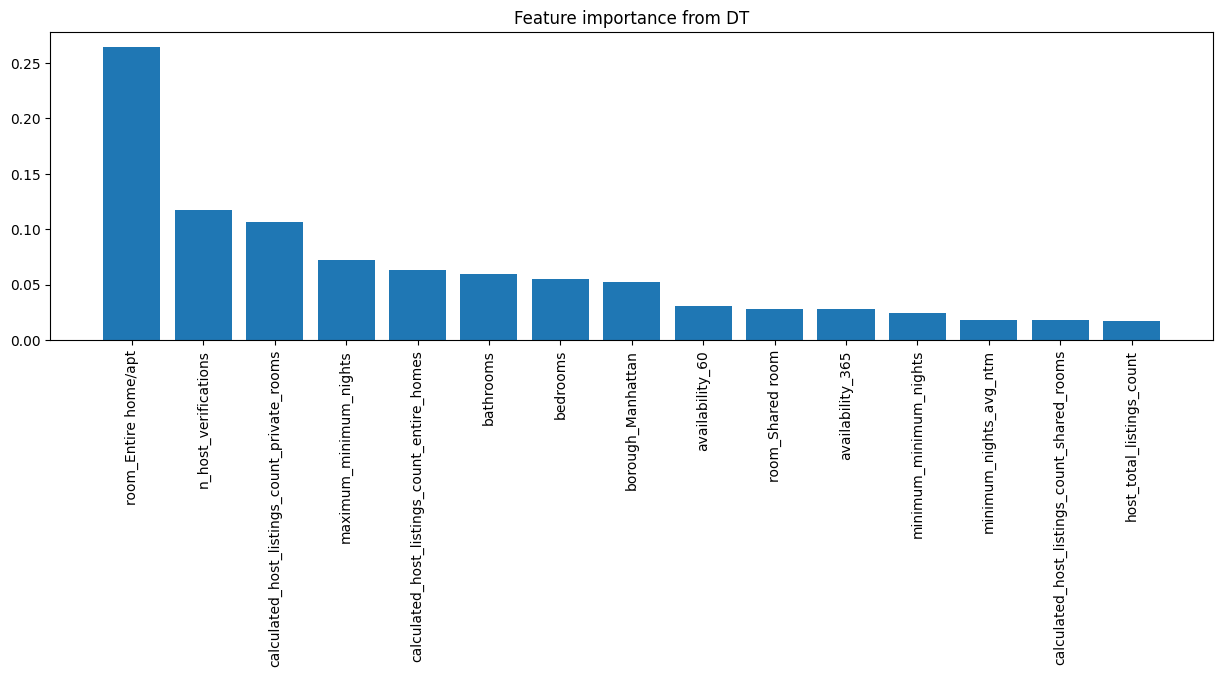

In [15]:
# get most important features from trained DT
fi = DT_model.feature_importances_

# get most important features by name
names_sorted = [x for _,x in sorted(zip(fi, dt_X_train.columns.values), reverse = True)]

# plot
fig, ax = plt.subplots(figsize=(15,4))

ax.bar(np.arange(15), sorted(DT_model.feature_importances_, reverse=True)[:15])
ax.set_xticks(np.arange(15))
ax.set_xticklabels(names_sorted[:15], rotation = 90)
plt.title('Feature importance from DT')

The top features on this chart are worth including in the neural net features list. 

## Project Plan
After inspecting the data and considering a few approaches, I decided to remove the amenities feature as there were over two thousand unique values (within each list) and many were uniquely user-entered. I thought about picking specific amenities to one hot encode but ultimately decided against it since that would involve a lot of manual intervention (for example someone might put "wifi" as an amenity while someone else puts "fast internet" and so on for each example). I decided against TF-IDF for similar reasons. TF-IDF actually makes little sense with this data because it might score "dove soap" over "soap" for its uniqueness.

The rest of the features I'm going to select based on the correlation matrix/ KDE plot and feature importance chart. Most features are already floats or ints which means they're already prepared for training. I've already encoded room types and boroughs so those are all set. All other object types (strings) will not be selected going forward.

I’ve decided to drop examples with a price over \$500 since that’s a really high nightly price which is probably caused by special circumstances like amenities and specific location which are not reflected in my training data. This seems reasonable given only 2.96% of examples are above 500 dollars.

I’m also going to need to scale some features since most of my feature values are low, especially for one-hot encoded and/or binary features.

I'll settle on the learning rate, loss function, optimization function, and number/type of hidden layers through iterative investigation.

I plan to train my model by splitting my data into training and test sets. I'll tune the model with the training data and confirm the accuracy of the final model with the test set. The test set is only used at the very end.

Since this is a regression model I’m using $R^2$, Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE) as my metrics:
* $R^2$ is a measure of the proportion of variability in the prediction that the model was able to make using the test data. It represents the proportion of the variance for a dependent variable that’s explained by an independent variable. This is normalized so that a value of 1 indicates that all variance in price is explained by the model and a value of 0 indicates no variance is explained.
* **MAE** is the average absolute difference between actual values and predicted values. Here, that’s how many dollars off the model predictions are on average. That makes this a particularly helpful metric for this project.
* **RMSE** is the average magnitude of the errors between predicted values and actual values. Lower values represent better model performance since the average error is less.

The feature list is below, sorted by the source:

In [16]:
new_feature_list = [
	
	# From DT & corr matrix
	'room_Entire home/apt',
	'bedrooms',
	'borough_Manhattan',
	'availability_60',
	
	# From DT feature importance
	'calculated_host_listings_count_private_rooms',
	'bathrooms',
	'room_Shared room',
	'maximum_minimum_nights',
	
	# From corr matrix
	'accommodates',
	'beds', # note that is different from bedrooms
	'room_Hotel room',
	'review_scores_location',
	'review_scores_cleanliness',
	'borough_Queens',
	'minimum_nights',
	'borough_Brooklyn',
	'borough_Queens',
	'host_is_superhost',
	
	# My intuition
	'borough_Bronx',
    'borough_Staten Island',
]

## Implementation

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras as keras
from tensorflow.keras.regularizers import l2
import time

2024-08-03 01:26:49.369540: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-03 01:26:49.369566: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Data Preparation

Note that boroughs and rooms have already been one-hot encoded.

I'm removing examples with missing data for `bedrooms` and `beds` because these are important, high correlation features. I don't want to set the missing values as the mean of the column since that would be training the model on potentially inaccurate information and I think there's enough data remaining to just remove them.

In [18]:
df = df.dropna(subset=['bedrooms', 'beds'])
df = df[['price']+new_feature_list]
df.head()

,price,room_Entire home/apt,bedrooms,borough_Manhattan,availability_60,calculated_host_listings_count_private_rooms,bathrooms,room_Shared room,maximum_minimum_nights,accommodates,...,room_Hotel room,review_scores_location,review_scores_cleanliness,borough_Queens,minimum_nights,borough_Brooklyn,borough_Queens,host_is_superhost,borough_Bronx,borough_Staten Island
1,75.0,1,1.0,0,6,0,1.0,0,1.0,3,...,0,4.71,4.49,0,1,1,0,True,0,0
2,275.0,1,2.0,0,3,0,1.5,0,5.0,4,...,0,4.50,5.00,0,5,1,0,True,0,0
3,68.0,0,1.0,1,16,1,1.0,0,2.0,2,...,0,4.87,3.73,0,2,0,0,True,0,0
4,75.0,0,1.0,1,0,1,1.0,0,2.0,1,...,0,4.94,4.82,0,2,0,0,True,0,0
7,62.0,0,1.0,1,4,1,1.0,0,30.0,1,...,0,4.84,4.96,0,30,0,0,True,0,0


In [19]:
# remove examples where price is really higher per as these are uncommon outliers that aren't reflected well in the data provided. 
df = df[df['price'] < 500]
df.shape

(23212, 21)

Scale minimum and max nights because the values can be huge compared to the rest of the data.

In [20]:
scaler = MinMaxScaler()

to_scale = ['maximum_minimum_nights', 'minimum_nights', 'review_scores_location', 'review_scores_cleanliness', 'availability_60']
df[to_scale] = scaler.fit_transform(df[to_scale])

In [21]:
# Convert the df to floats for Keras
df = df.astype('float64')
df.head()

,price,room_Entire home/apt,bedrooms,borough_Manhattan,availability_60,calculated_host_listings_count_private_rooms,bathrooms,room_Shared room,maximum_minimum_nights,accommodates,...,room_Hotel room,review_scores_location,review_scores_cleanliness,borough_Queens,minimum_nights,borough_Brooklyn,borough_Queens,host_is_superhost,borough_Bronx,borough_Staten Island
1,75.0,1.0,1.0,0.0,0.100000,0.0,1.0,0.0,0.000000,3.0,...,0.0,0.942,0.898,0.0,0.000000,1.0,0.0,1.0,0.0,0.0
2,275.0,1.0,2.0,0.0,0.050000,0.0,1.5,0.0,0.003203,4.0,...,0.0,0.900,1.000,0.0,0.003203,1.0,0.0,1.0,0.0,0.0
3,68.0,0.0,1.0,1.0,0.266667,1.0,1.0,0.0,0.000801,2.0,...,0.0,0.974,0.746,0.0,0.000801,0.0,0.0,1.0,0.0,0.0
4,75.0,0.0,1.0,1.0,0.000000,1.0,1.0,0.0,0.000801,1.0,...,0.0,0.988,0.964,0.0,0.000801,0.0,0.0,1.0,0.0,0.0
7,62.0,0.0,1.0,1.0,0.066667,1.0,1.0,0.0,0.023219,1.0,...,0.0,0.968,0.992,0.0,0.023219,0.0,0.0,1.0,0.0,0.0


In [22]:
# Split data for training and testing
X = df.drop(columns='price')
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

# Convert to numpy arrays for Keras
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [23]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(11606, 20)
(11606,)
(11606, 20)
(11606,)


### Model Building and Training
Create the model, define the optimization algorithm, define the loss function, and compile the model.

The input layer's input shape is equal to the number of features of each training example.

Since this is a regression problem, our output layer should be linear so that our prediction is a real number. Classification functions, like sigmoid, which makes a prediction between 0 and 1, won't work here.

In [24]:
# Create the model
model = keras.Sequential()

# Input layer
model.add(keras.layers.InputLayer(input_shape=(X_train.shape[1]), name='input'))

# Hidden Layer 1 - removed because of overfitting
# model.add(keras.layers.Dense(units=64, activation='relu', name='hl_1', kernel_regularizer=l2(0.01)))
# model.add(keras.layers.Dropout(0.2))  # Add dropout for regularization

# Hidden Layer 2
model.add(keras.layers.Dense(units=32, activation='relu', name='hl_2', kernel_regularizer=l2(0.01)))
model.add(keras.layers.Dropout(0.2))  # Add dropout for regularization

# Hidden Layer 3
model.add(keras.layers.Dense(units=16, activation='relu', name='hl_3', kernel_regularizer=l2(0.01)))

# Output Layer
output_layer = keras.layers.Dense(units=1, activation='linear', name='output')
model.add(output_layer)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hl_2 (Dense)                 (None, 32)                672       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
hl_3 (Dense)                 (None, 16)                528       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


2024-08-03 01:26:50.479817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-08-03 01:26:50.479840: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-08-03 01:26:50.479857: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (i-016e883cadaad8f94): /proc/driver/nvidia/version does not exist
2024-08-03 01:26:50.480039: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


I was back and forth between mean squared error and MAE as my loss function but I think mean squared error is slightly better here based on the results.

In [25]:
# Loss function
# loss_function = keras.losses.MeanAbsoluteError()
loss_function = keras.losses.MeanSquaredError()

I started with SGD as my optimizer but switched to [Adam](https://www.geeksforgeeks.org/adam-optimizer/), a similar gradient descent method, because it seemed to work better with large datasets. I immediately got better results so I'm sticking with it.

In [26]:
# Optimization Algorithm
opt_alg = keras.optimizers.Adam(learning_rate=.01) # learning rate set here

I'm using R^2 as the metric to measure the proportion of variability. This is built into keras with the method `R2Score()` but I don't have access to that in this VM so I'm essentially redefining it here as given in the docs.

In [27]:
# R2 metric
def r2(y_true, y_pred):
    sum_square_res = keras.backend.sum(keras.backend.square(y_true - y_pred))
    total = keras.backend.sum(keras.backend.square(y_true - keras.backend.mean(y_true)))
    return 1 - sum_square_res / (total + keras.backend.epsilon())

In [28]:
# Compile Model
model.compile(optimizer=opt_alg, loss=loss_function, metrics=[keras.metrics.RootMeanSquaredError(name='rmse'), r2, 'mae']) 

#### Fit Model to Data

The logger function from BreakThoughTech AI course materials to output every 50 epochs.

In [29]:
class ProgBarLoggerNEpochs(keras.callbacks.Callback):

    def __init__(self, num_epochs: int, every_n: int = 50):
        self.num_epochs = num_epochs
        self.every_n = every_n

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n == 0:
            s = 'Epoch [{}/ {}]'.format(epoch + 1, self.num_epochs)
            logs_s = ['{}: {:.4f}'.format(k.capitalize(), v)
                for k, v in logs.items()]
            s_list = [s] + logs_s
            print(', '.join(s_list))

The `fit()` method learns model parameters from the training data. It returns a history object with info for each epoch. The goal is to lower the RMSE and raise the R2.

In [30]:
num_epochs = 50 # number of epochs

t0 = time.time()

history = model.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    verbose=0,
    callbacks=[ProgBarLoggerNEpochs(num_epochs, every_n=5)]
)

t1 = time.time()
print(f'Elapsed time: {t1-t0:.2f}s')

2024-08-03 01:26:50.568360: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-08-03 01:26:50.568731: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2649995000 Hz


Epoch [5/ 50], Loss: 4292.0664, Rmse: 65.4429, R2: 0.4187, Mae: 45.3646
Epoch [10/ 50], Loss: 4178.8511, Rmse: 64.5068, R2: 0.4411, Mae: 44.6876
Epoch [15/ 50], Loss: 3963.3369, Rmse: 62.7522, R2: 0.4695, Mae: 43.4379
Epoch [20/ 50], Loss: 3956.0317, Rmse: 62.6527, R2: 0.4697, Mae: 43.1164
Epoch [25/ 50], Loss: 3891.5337, Rmse: 62.1023, R2: 0.4784, Mae: 42.6725
Epoch [30/ 50], Loss: 3928.4497, Rmse: 62.3673, R2: 0.4790, Mae: 42.7180
Epoch [35/ 50], Loss: 3861.1660, Rmse: 61.8027, R2: 0.4782, Mae: 42.5891
Epoch [40/ 50], Loss: 3839.3782, Rmse: 61.6045, R2: 0.4824, Mae: 42.3854
Epoch [45/ 50], Loss: 3840.3708, Rmse: 61.5928, R2: 0.4930, Mae: 42.3004
Epoch [50/ 50], Loss: 3784.7981, Rmse: 61.1296, R2: 0.4939, Mae: 42.0593
Elapsed time: 9.57s


#### Evaluation

Visualize training loss and accuracy.

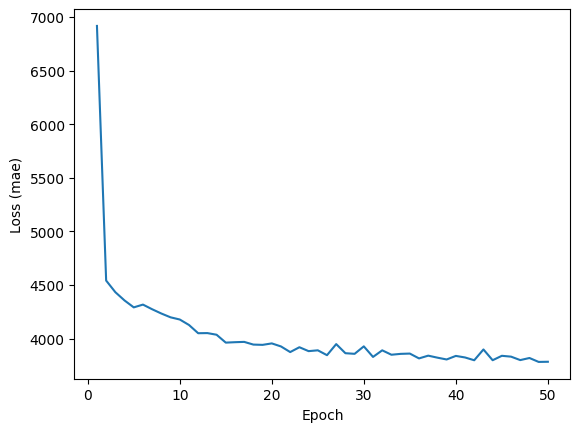

In [31]:
plt.plot(range(1, num_epochs + 1), history.history['loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss (mae)')
plt.show()

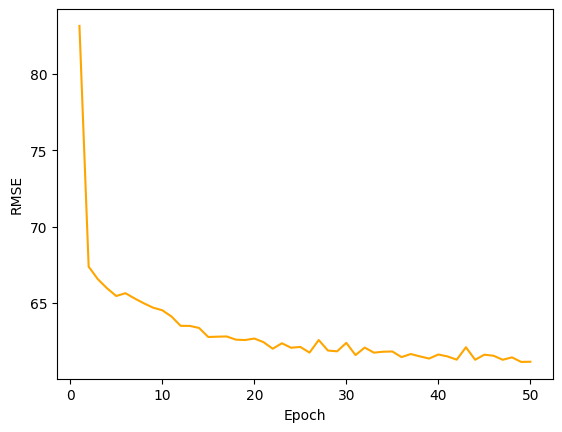

In [32]:
plt.plot(range(1, num_epochs + 1), history.history['rmse'], color='orange')

plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

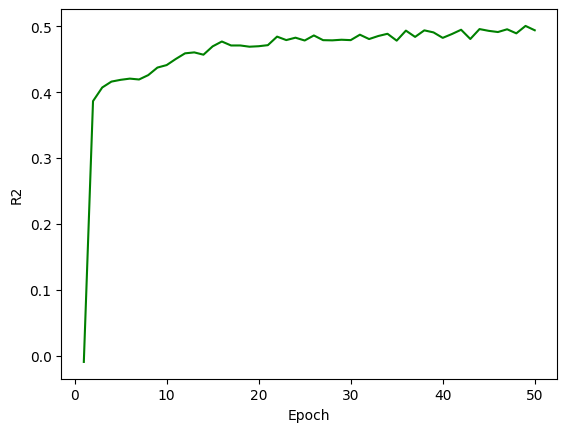

In [33]:
plt.plot(range(1, num_epochs + 1), history.history['r2'], color='green')

plt.xlabel('Epoch')
plt.ylabel('R2')
plt.show()

#### Checking with Test data

In [34]:
# Make predictions
predictions = model.predict(X_test)

# Print predictions and actual values
for pred, actual in zip([round(pred[0], 1) for pred in predictions[:20]], y_test[:20]):
    difference = round(pred - actual, 1)
    print(f"Predicted: {pred} | Actual: {actual} | Difference: {difference}")

Predicted: 124.69999694824219 | Actual: 95.0 | Difference: 29.7
Predicted: 252.10000610351562 | Actual: 275.0 | Difference: -22.9
Predicted: 77.0999984741211 | Actual: 48.0 | Difference: 29.1
Predicted: 78.5 | Actual: 89.0 | Difference: -10.5
Predicted: 26.899999618530273 | Actual: 38.0 | Difference: -11.1
Predicted: 86.19999694824219 | Actual: 90.0 | Difference: -3.8
Predicted: 74.5999984741211 | Actual: 58.0 | Difference: 16.6
Predicted: 66.0 | Actual: 41.0 | Difference: 25.0
Predicted: 194.5 | Actual: 149.0 | Difference: 45.5
Predicted: 79.19999694824219 | Actual: 65.0 | Difference: 14.2
Predicted: 103.9000015258789 | Actual: 92.0 | Difference: 11.9
Predicted: 174.10000610351562 | Actual: 300.0 | Difference: -125.9
Predicted: 149.8000030517578 | Actual: 175.0 | Difference: -25.2
Predicted: 213.10000610351562 | Actual: 180.0 | Difference: 33.1
Predicted: 79.19999694824219 | Actual: 96.0 | Difference: -16.8
Predicted: 128.39999389648438 | Actual: 160.0 | Difference: -31.6
Predicted: 2

In [35]:
# Evaluation metrics with the test data

# Mean absolute error
mae_eval = mean_absolute_error(y_test, predictions)
print(f'MAE: {mae_eval} (number of dollars the prediction is off by on average)')

# Root Mean Squared Error
mse_eval = mean_squared_error(y_test, predictions)
rmse_eval= np.sqrt(mse_eval)
print(f'RMSE: {rmse_eval} (a lower value is better here)')

# R^2
r2 = r2_score(y_test, predictions)
print(f'R2: {r2} (a higher value close to 1 here is good)')

MAE: 40.42060232022785 (number of dollars the prediction is off by on average)
RMSE: 60.432572076350986 (a lower value is better here)
R2: 0.5336964784165437 (a higher value close to 1 here is good)


#### Conclusion
I got an MAE of 40.42, RMSE of 60.43, and $R^2$ of 0.53 on the test data. These are not particularly high values but it’s a big improvement from the decision tree trained earlier which had an $R^2$ of 0.196. It’s also an improvement from earlier iterations of the neural net. Overfitting was tricky because it could start happening quickly, but the charts helped set the epochs to a reasonable value before the lines flattened out.

My goal for this project was to get an MAE under $50 since Airbnb prices are set by hosts and can be very subjective. Although an MAE of 40 is high, it’s a pretty good result for an application like this, especially without additional information about exact locations or amenities. The model doesn’t know if it’s looking at a luxury apartment or specific view, things that absolutely impact the price.
